#  A bit more on feature importances:

In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
from ocp_table_tpot.globals import Globals as gd
from tpot import TPOTRegressor
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase,TimeSeriesSplitImproved
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split,cross_val_predict
from skgarden.quantile import RandomForestQuantileRegressor
from sklearn.metrics import mean_squared_error,make_scorer
from copy import copy
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline, make_union
data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')

In [32]:
year = 2019
tgt = 'rougher.output.recovery'

X = data_dict[year][f'X_train_tsclean']
print(X.shape)
y = data_dict[year]['y_train']
mask = data_dict[year]['mask']
exclude_pts = data_dict[year]['excl'].set_index('date').tz_localize('UTC')
X.columns = [x.replace("\"","") for x in X.columns]
inds = mask.index.difference(exclude_pts.index)
mask=mask[inds]#y.isna().sum()
X = X.filter(regex  ="rougher|hour|dayw",axis = 1)

X=X.loc[inds,:]
y=y.loc[inds,:]

X = X[mask]
y = y[mask][tgt]
print(X.shape)

#X.shape


(16859, 1207)
(12838, 796)


In [33]:
set(X.columns)

{'daily_avg_rougher',
 'dayw',
 'deriv1_encod_dif_rougher.input.feed_fe',
 'deriv1_encod_rel_rougher.input.feed_fe',
 'deriv1_encod_rel_rougher.input.feed_zn',
 'deriv1_encod_val_rougher.input.feed_fe',
 'deriv1_encod_val_rougher.input.feed_pb',
 'deriv1_encod_val_rougher.input.feed_zn',
 'deriv1_rougher.input.feed_fe',
 'deriv1_rougher.input.feed_pb',
 'deriv1_rougher.input.feed_rate',
 'deriv1_rougher.input.feed_size',
 'deriv1_rougher.input.feed_sol',
 'deriv1_rougher.input.feed_zn',
 'deriv1_rougher.input.feed_zn_diff_encod_dif_rougher.input.feed_pb',
 'deriv1_rougher.input.feed_zn_diff_encod_val_primary_cleaner.input.copper_sulfate',
 'deriv1_rougher.input.feed_zn_diff_secondary_cleaner.state.floatbank2_a_air',
 'deriv1_rougher.input.feed_zn_diff_value__minimum_p6_rougher.input.floatbank11_xanthate',
 'deriv1_rougher.input.feed_zn_diff_value__quantile__q_0.95_p24_rougher.input.feed_fe',
 'deriv1_rougher.input.feed_zn_poly_encod_dif_rougher.input.feed_pb',
 'deriv1_rougher.input.fe

In [34]:
model_lgb = lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=900,random_state=40,
                              **{'num_leaves': 45, 'feature_fraction': '0.469', 'bagging_fraction': '0.87', 'lambda_l1': 14.538132143499544})
#model_lgb.fit(X,y)
sc = cross_val_score(model_lgb,X,y,cv = KFold(5,shuffle=False),scoring = 'neg_mean_absolute_error')
print(sc)
sc.mean()
model_lgb.fit(X,y)

[-5.46031025 -4.70369721 -4.13507738 -2.97108029 -5.18438717]


LGBMRegressor(bagging_fraction='0.87', boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, feature_fraction='0.469',
       importance_type='split', lambda_l1=14.538132143499544,
       learning_rate=0.05, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=900,
       n_jobs=-1, num_leaves=45, objective='mae', random_state=40,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

# Shap values for the model with lagdiffs

C extension was not built during install!


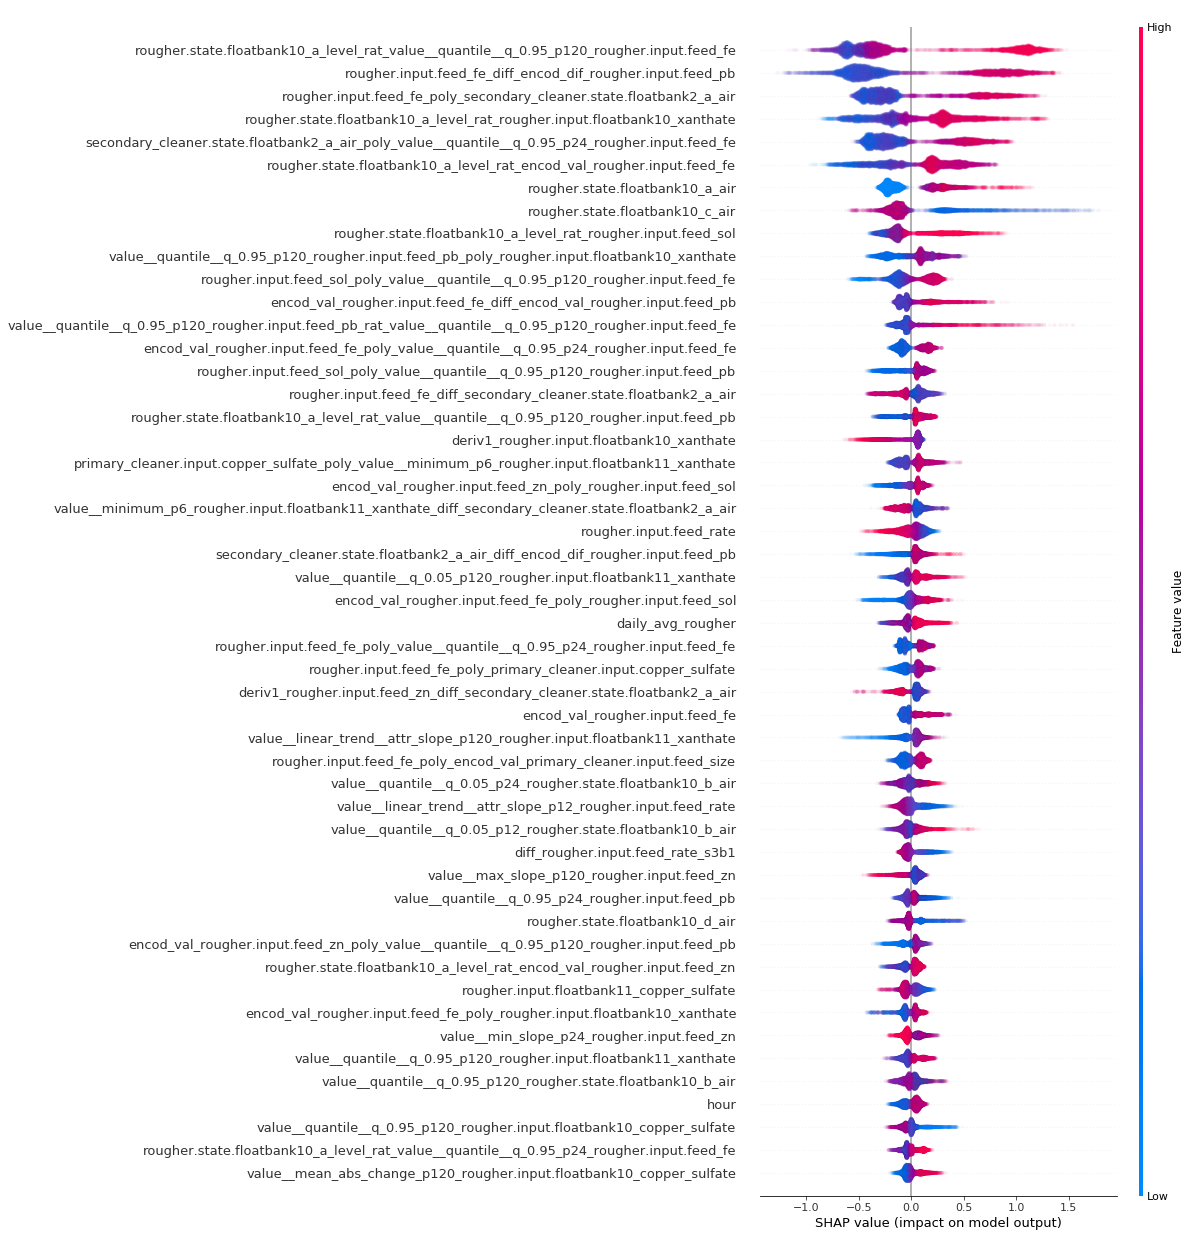

In [35]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model_lgb)
#X_sub = X.sample(frac=0.1)
shap_values = explainer.shap_values(X)
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values, X_sub,matplotlib=True)
shap.summary_plot(shap_values, X,max_display = 50,alpha= 0.03)

In [36]:
# pull as dataframe
#pd.DataFrame({'feature_shap':np.abs(shap_values).mean(0),'feature':X.columns}).sort_values('feature_shap', ascending=False).to_csv('shap-importance-final.csv',float_format='%.3f',index=False)
#pd.DataFrame({'feature_shap':np.abs(shap_values).mean(0),'feature':X.columns}).sort_values('feature_shap', ascending=False).to_csv('shap-importance-rougher.csv',float_format='%.3f',index=False)
feat_imp_shap = pd.DataFrame({'feature_shap':np.abs(shap_values).mean(0),'feature':X.columns}).sort_values('feature_shap', ascending=False)
feat_imp_shap.to_csv('shap-importance-rougher-diff_deriv_normalized_with_interaction.csv',float_format='%.5f',index=False)


## Repeat for the final

(16859, 1207)
(12838, 1207)
C extension was not built during install!


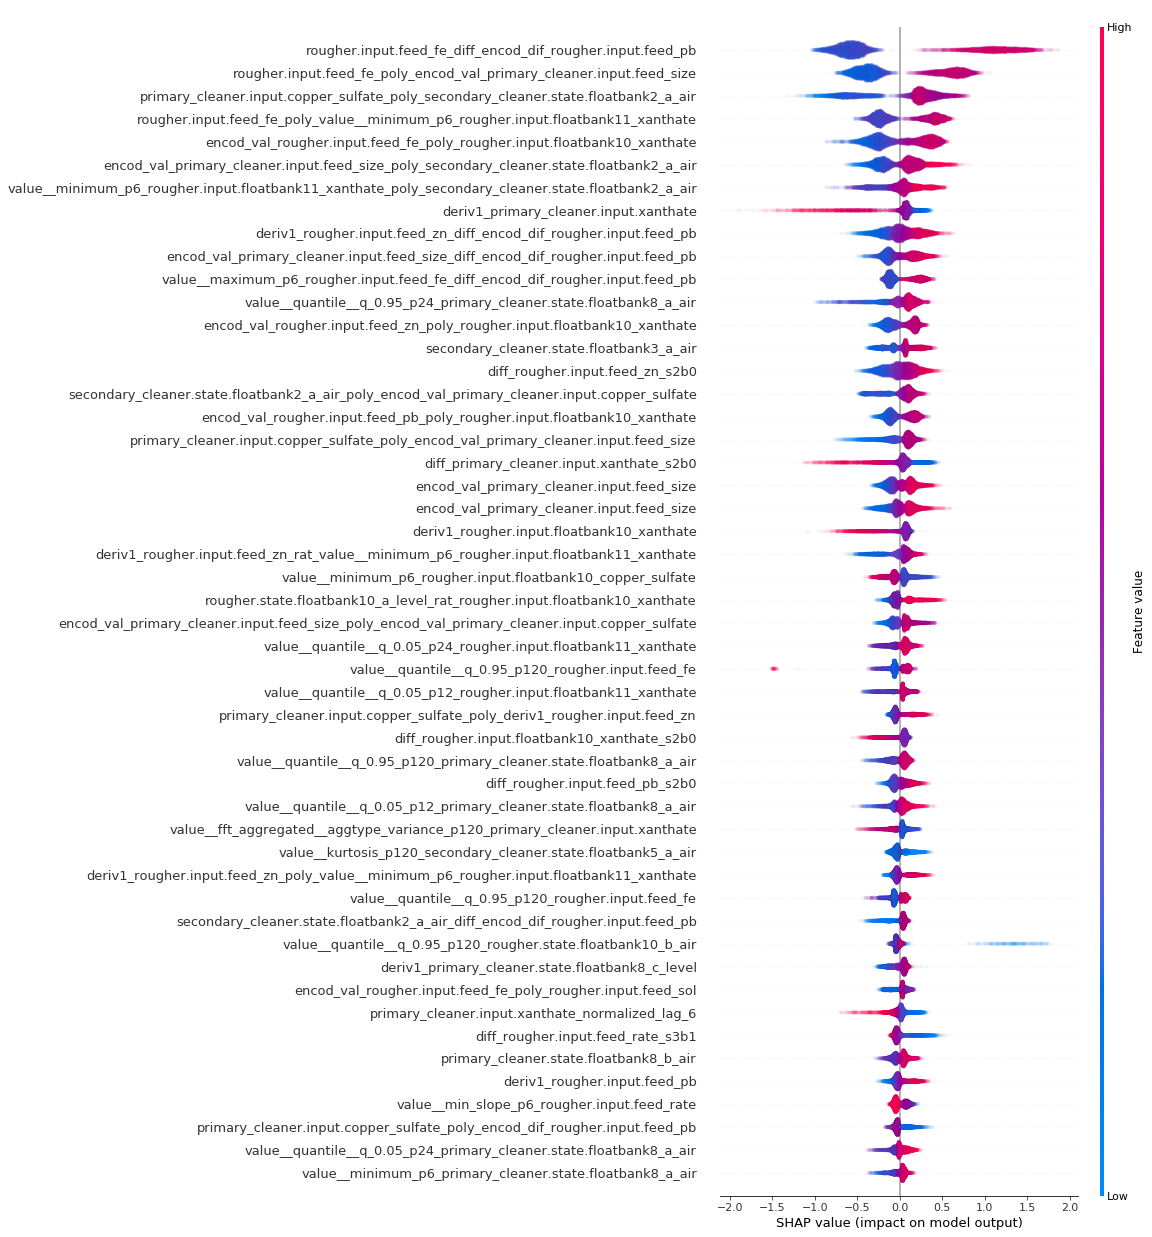

In [37]:
year = 2019
tgt = 'final.output.recovery'
X = data_dict[year][f'X_train_tsclean']
print(X.shape)
y = data_dict[year]['y_train']
mask = data_dict[year]['mask']
exclude_pts = data_dict[year]['excl'].set_index('date').tz_localize('UTC')
X.columns = [x.replace("\"","") for x in X.columns]
inds = mask.index.difference(exclude_pts.index)
mask=mask[inds]#y.isna().sum()
#X = X.filter(regex  ="rougher|hour|dayw",axis = 1)
X=X.loc[inds,:]
y=y.loc[inds,:]

X = X[mask]
y = y[mask][tgt]
print(X.shape)


model_lgb = lgb.LGBMRegressor(objective='mae',
                              learning_rate=0.05, n_estimators=900,random_state=40,
                              **{'num_leaves': 45, 'feature_fraction': '0.469', 'bagging_fraction': '0.87', 'lambda_l1': 14.538132143499544})
#model_lgb.fit(X,y)
#sc = cross_val_score(model_lgb,X,y,cv = KFold(5,shuffle=False),scoring = 'neg_mean_absolute_error')
#print(sc)
#sc.mean()
model_lgb.fit(X,y)

explainer = shap.TreeExplainer(model_lgb)
#X_sub = X.sample(frac=0.1)
shap_values = explainer.shap_values(X)
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values, X_sub,matplotlib=True)
shap.summary_plot(shap_values, X,max_display = 50,alpha= 0.03)

In [38]:
feat_imp_shap = pd.DataFrame({'feature_shap':np.abs(shap_values).mean(0),'feature':X.columns}).sort_values('feature_shap', ascending=False)
feat_imp_shap.to_csv('shap-importance-final-diff_deriv_normalized_with_interaction.csv',float_format='%.5f',index=False)